In [5]:
import json
import os
import numpy as np
from scipy.sparse import csr_matrix
from dominate import document
from dominate.tags import ul, li, a, h1, h2

In [2]:
class PersonalizedPageRank:
    
    def __init__(self, graphFile, contentFile):
        
        self.graph_file = graphFile
        self.content_file = contentFile
        
        self.generate_graph() # generate self.graph, self.num_nodes
        self.generate_contents() # generate self.contents
        self.compute_stochastic_matrix() # generate self.R
        
    def generate_graph(self):
        with open(self.graph_file, 'r') as f:
            # We have the graph encoded as an adjacency list in a JSON file 
            g = json.load(f)
        self.graph = g
        self.num_nodes = len(g.keys())
        
    def generate_contents(self):
        with open(self.content_file, 'r') as f:
            # We have the graph encoded as an adjacency list in a JSON file 
            c = json.load(f)
        self.contents = c
        
    def compute_stochastic_matrix(self):
        # we make a dictionary saving for each key in the graph
        # the corresponding index in the matrix
        key_to_pos = dict(zip(self.graph.keys(), range(0,self.num_nodes)))
        row = []
        col = []
        data = []

        for key in self.graph.keys():
            for edge in self.graph[key]:
                row.append(key_to_pos[key])
                col.append(key_to_pos[edge])
                data.append(1/len(self.graph[key]))
        R = csr_matrix((data, (row, col)), shape=(self.num_nodes, self.num_nodes))
    
        self.R = R
    
    def generate_seed(self, topic):
        key_to_pos = dict(zip(self.graph.keys(), range(0,self.num_nodes)))
        seeds = np.zeros(self.num_nodes)

        for key in self.contents.keys():
            lower_key_content = [x.lower() for x in self.contents[key]]
            mask = [topic in x for x in lower_key_content]
            if any(mask):
                seeds[key_to_pos[key]] = 1

        if (np.sum(seeds)!=0):
            self.J = seeds/np.sum(seeds)
        else: 
            self.J = seeds
        
    def PersonalizedPageRank_iteration(self, x, alpha):
        P = (1 - alpha) * self.R
        x_prime = (P.T).dot(x) + alpha * self.J
        return x_prime
    
    def compute_PersonalizedPageRank(self, topic, alpha, epsilon):
        # The jump vector is imply a vector of ones divided by its length
        self.generate_seed(topic)
        if (np.sum(self.J)==0):
            print('There are no pages related to '+topic)
            x = np.zeros(self.num_nodes)
            return x
        # The starting point can be a uniform distribution across all nodes
        # ...or a random stochastic vector
        x = np.random.rand(self.num_nodes)
        x = x/x.sum()
        # We can now iterate until the norm one of the changes in the
        # last iteration goes below epsilon
        err = np.inf # initially infinity
        while (err > epsilon):
            x_new = self.PersonalizedPageRank_iteration(x, alpha)
            err = (abs(x_new - x)).sum()
            x = x_new
        return x

In [4]:
class User:

    def __init__(self, name, surname):
        self.name = name
        self.surname = surname

        self.rates = {}
        
    def getTopicRate(self, topic, rate):
        
        self.rates[topic] = rate

In [5]:
class IRsystem():

    def __init__(self, user, pagerank):
        self.user = user
        self.pagerank = pagerank

    def compute_weights(self):
        
        self.weights = np.array([self.user.rates[x] for x in self.user.rates.keys()])
        self.weights = self.weights/np.sum(self.weights) 
    
    
    def compute_final_pagerank(self, alpha, epsilon):
        
        self.compute_weights()
        xs = []
        
        for topic in self.user.rates.keys():
            x = self.pagerank.compute_PersonalizedPageRank(topic, alpha, epsilon)
            xs.append(x)
        
        xs = np.array(xs)
        self.pagerank_vector = np.dot(self.weights, xs) 
        
        self.dict = {}
        for i, k in enumerate(self.pagerank.graph.keys()):
            self.dict[k] = self.pagerank_vector[i]

    def write_result(self):
        paths = []
        for w in sorted(self.dict, key=self.dict.get, reverse=True):
            not_useful_pages= ['User', 'Category', 'Wiki','Help','Image','Special','License', 'GFDL', 'language']
            mask = [x not in w for x in not_useful_pages]
            if all(mask):
                paths.append('simple/'+w)
                #print(w, self.dict[w])

        with document(title='Result') as doc:
            h1('WikipediaSearch')
            h2('Result for '+self.user.name+' '+self.user.surname)
            for path in paths:
                name = path[13:]
                name = name.replace('.html','')
                ul(li(a(name, href=path), __pretty=False))


        with open('result.html', 'w') as f:
            f.write(doc.render())

In [170]:
user = User(name='Roberto', surname='Corti')

for i in range(0, 5):
    topic = input('Topic '+str(i+1)+': ')

    rate = int(input('Rate '+topic+ ' (lower=1, higher=5): '))

    while rate < 0 or rate > 5:
        rate = int(input('Not valid rate!!!\nRate '+topic+' (lower=1, higher=5): '))

    user.getTopicRate(topic, rate)

Topic 1: communism
Rate communism (lower=1, higher=5): 3
Topic 2: socialism
Rate socialism (lower=1, higher=5): 2
Topic 3: capitalism
Rate capitalism (lower=1, higher=5): 2
Topic 4: economics
Rate economics (lower=1, higher=5): 5
Topic 5: finance
Rate finance (lower=1, higher=5): 1


In [171]:
user.rates

{'communism': 3, 'socialism': 2, 'capitalism': 2, 'economics': 5, 'finance': 1}

In [141]:
p = PersonalizedPageRank(graphFile='wikipediaGraph_simple.json',
                         contentFile='wikipediaGraph_simple_contents.json')

In [172]:
%%time

system = IRsystem(user=user, pagerank=p)

system.compute_final_pagerank(alpha=0.2, epsilon=0.0001)

CPU times: user 4.12 s, sys: 31.2 ms, total: 4.15 s
Wall time: 4.08 s


In [173]:
%%time
system.write_result()

CPU times: user 2.06 s, sys: 7.08 ms, total: 2.07 s
Wall time: 1.17 s


In [144]:
sum(system.pagerank_vector)

0.9964982947124033

# Test Part

In [4]:
def read_graph(filename):
    with open(filename, 'r') as f:
        # We have the graph encoded as an adjacency list in a JSON file 
        g = json.load(f)
        # The data structure read from JSON is already "good enough" for us
        return g

In [231]:
key_to_pos = dict(zip(g.keys(), range(0,n)))

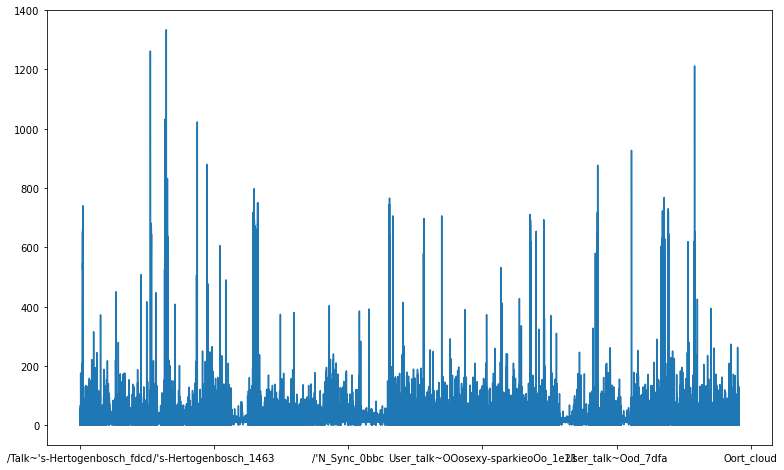

In [277]:
fig, ax = plt.subplots(figsize=(13,8))

idx = [key_to_pos[i] for i in key_to_pos.keys()]
labels = [x[6:] for x in key_to_pos.keys()]
labels = np.array([x[:-5] for x in labels])
ax.plot(idx, lists)

ax.set_xticklabels(labels)

plt.show()

In [6]:
g = read_graph('data/wikipediaGraph_simple_new.json')
contents = read_graph('data/wikipediaGraph_simple_contents_new.json')
n = len(g.keys())

edges = 0
for x in g.keys():
    edges += len(g[x])

print('Number of nodes: ', n)
print('Number of edges: ', edges)

Number of nodes:  49142
Number of edges:  1235150


In [44]:
valid_yes = ['y', 'Y', 'yes', 'YES']
valid_no = ['n', 'N', 'no', 'NO']

answer = input('Do you want to set the PageRank parameters? (default, alpha=0.2, epsilon=0.001) [y/n] ')

while not(answer in valid_yes or answer in valid_no):
    answer = input('Do you want to set the PageRank parameters? (default, alpha=0.2, epsilon=0.001) [y/n] ')

if answer in valid_yes:
    
    epsilon = float(input('Set epsilon: '))
    alpha = float(input('Set alpha: '))
    while alpha > 1:
        alpha = float(input('Not valid alpha!!!\nSet alpha: '))

elif answer in valid_no:
    epsilon = 0.001
    alpha = 0.2

Do you want to set the PageRank parameters? (default, alpha=0.2, epsilon=0.001) [y/n] n


In [45]:
print('alpha: ', alpha, ' epsilon: ', epsilon)

alpha:  0.2  epsilon:  0.001


In [207]:
R.tocsc

<bound method spmatrix.todok of <49142x49142 sparse matrix of type '<class 'numpy.float64'>'
	with 1096599 stored elements in Compressed Sparse Row format>>

In [7]:
def compute_R(graph):
    n = len(graph.keys())
    # we make a dictionary saving for each key in the graph
    # the corresponding index in the matrix
    key_to_pos = dict(zip(graph.keys(), range(0,n)))
    row = []
    col = []
    data = []

    for key in g.keys():
        for edge in g[key]:
            row.append(key_to_pos[key])
            col.append(key_to_pos[edge])
            data.append(1/len(g[key]))
    R = csr_matrix((data, (row, col)), shape=(n, n))
    
    return R

In [8]:
def PageRank_iteration(x, R, J, alpha):
    n = len(x)
    P = (1 - alpha) * R
    x_prime = (P.T).dot(x) + alpha * J
    return x_prime

In [9]:
def compute_PageRank(graph, alpha, epsilon):
    n = len(graph.keys())
    # We compute the transition matrix without the teleportation
    R = compute_R(graph)
    # The jump vector is imply a vector of ones divided by its length
    J = np.ones(n)/n
    # The starting point can be a uniform distribution across all nodes
    # x = np.ones(n)/n
    # ...or a random stochastic vector
    x = np.random.rand(n)
    x = x/x.sum()
    # We can now iterate until the norm one of the changes in the
    # last iteration goes below epsilon
    err = np.inf # initially infinity
    while (err > epsilon):
        x_new = PageRank_iteration(x, R, J, alpha)
        err = (abs(x_new - x)).sum()
        print(err)
        x = x_new
    print("PageRank scores:")
    print(x.shape)
    dictionary = {}
    for i, k in enumerate(graph.keys()):
        #print(f"{k}: {x[0,i]}")
        dictionary[k] = x[i]
    return x, dictionary

In [281]:
x, d = compute_PageRank(g, alpha = 0.1, epsilon=0.0001)

1.3344461493923954
0.5985276353897879
0.20214260547335317
0.0676561611556368
0.027044259924078686
0.012629520700934383
0.006218053662063593
0.0032240136545232797
0.0017668033395113161
0.0010585503345919782
0.0007052209559616103
0.0005156859575343476
0.0004082171961992393
0.00034326002862915294
0.00029992533232976905
0.0002680622458403545
0.0002408222151272078
0.00021643243873304175
0.00019451432197936533
0.00017481371974095578
0.00015710695710677237
0.00014119271306955794
0.00012688985275643733
0.00011403543560370689
0.00010248292712134867
9.210056737560958e-05
PageRank scores:
(49142,)


In [10]:
x, d = compute_PageRank(g, alpha = 0.1, epsilon=0.0001)

1.335567462736564
0.598578089790906
0.20222147054712894
0.0678206542121971
0.02714829201326582
0.012697096991756784
0.006259425514372126
0.003247737318271161
0.0017790853660163922
0.0010652291860271752
0.0007091873554353299
0.0005183764243578857
0.0004103749080399136
0.00034509837776752067
0.0003015421795867788
0.00026950800163949524
0.0002421217395492202
0.00021760102065089494
0.00019556500434265273
0.00017575827785791488
0.0001579560328720857
0.0001419559084348352
0.0001275758213273539
0.00011465197024062269
0.00010303704159115928
9.259857175812169e-05
PageRank scores:
(49142,)


In [18]:
paths = []
for w in sorted(d, key=d.get, reverse=True):
    not_useful_pages= ['User', 'Category', 'Wiki','Help','Image','Special','License', 'GFDL', 'language']
    mask = [x not in w for x in not_useful_pages]
    if all(mask):
        paths.append('../data/simple/'+w)


with document(title='Standard PageRank result') as doc:
    h1('Wikipedia PageRank')
    h2('alpha = 0.1, epsilon = 0.0001')
    for path in paths:
        name = path[21:]
        name = name.replace('.html','')
        ul(li(a(name, href=path), __pretty=False))

with open('result/standard_pagerank_result_new.html', 'w') as f:
    f.write(doc.render())


In [16]:
paths

['../data/simple/u/n/i/United_States_09d4.html',
 '../data/simple/l/a/w/Law.html',
 '../data/simple/e/n/c/Encyclopedia.html',
 '../data/simple/i/n/t/Internet_Protocol_7ac7.html',
 '../data/simple/b/o/o/Book.html',
 '../data/simple/o/p/e/Open_content.html',
 '../data/simple/m/o/n/Money.html',
 '../data/simple/f/i/l/Film.html',
 '../data/simple/c/o/p/Copyleft.html',
 '../data/simple/2/0/0/2001.html',
 '../data/simple/d/i/c/Dictionary.html',
 '../data/simple/r/u/l/Rule.html',
 '../data/simple/s/o/n/Song.html',
 '../data/simple/n/o/n/Non-profit.html',
 '../data/simple/w/e/b/Website.html',
 '../data/simple/m/o/v/Movie.html',
 '../data/simple/f/a/i/Fair_use.html',
 '../data/simple/e/x/c/Exception.html',
 '../data/simple/w/e/b/Web_page.html',
 '../data/simple/c/o/p/WP~COPY_08ab.html',
 '../data/simple/c/r/_/WP~CR_d625.html',
 '../data/simple/w/e/b/Webpage.html',
 '../data/simple/j/a/n/January.html',
 '../data/simple/p/u/b/Public_domain.html',
 '../data/simple/t/h/e/Thesaurus.html',
 '../data/

In [53]:
def generate_seed(topic, g, contents):    

    n = len(contents.keys())
    key_to_pos = dict(zip(g.keys(), range(0,n)))
    seeds = np.zeros(n)

    for key in contents.keys():
        lower_key_content = [x.lower() for x in contents[key]]
        mask = [topic in x for x in lower_key_content]
        #if topic in lower_key_content:
        if any(mask):
            seeds[key_to_pos[key]] = 1
    if (sum(seeds) != 0):
        seeds = seeds/sum(seeds)
        return seeds
    else: 
        return topic+' is not present'

In [60]:
def compute_PersonalizedPageRank(graph, topic, contents, alpha, epsilon):
    n = len(graph.keys())
    # We compute the transition matrix without the teleportation
    R = compute_R(graph)
    # The jump vector is imply a vector of ones divided by its length
    J_s = generate_seed(topic, graph, contents)
    #J = np.ones(n)/n
    # The starting point can be a uniform distribution across all nodes
    # x = np.ones(n)/n
    # ...or a random stochastic vector
    x = np.random.rand(n)
    x = x/x.sum()
    # We can now iterate until the norm one of the changes in the
    # last iteration goes below epsilon
    err = np.inf # initially infinity
    while (err > epsilon):
        x_new = PageRank_iteration(x, R, J_s, alpha)
        #err = (abs(x_new - x)).sum()
        err = np.sum(np.abs(x_new-x))
        print(err)
        x = x_new
    #print("PageRank scores:")
    #print(x.shape)
    dictionary = {}
    for i, k in enumerate(graph.keys()):
        #print(f"{k}: {x[0,i]}")
        dictionary[k] = x[i]
        
    
    return x, dictionary

In [187]:
%%time

topic = input('Insert the topic: ')

x, d = compute_PersonalizedPageRank(g, topic, contents, 0.15, 0.0001)

Insert the topic: disco
1.5189923955220945
0.6652596797328235
0.21424745789834254
0.06564865450723423
0.022894221494285445
0.009318905245377315
0.004256709240492838
0.002020069737368775
0.0010265540852075605
0.000549294554624136
0.0003116507477714042
0.0001954674276644644
0.00013587531481901012
0.00010188421216255332
8.098654635379127e-05
CPU times: user 859 ms, sys: 11.8 ms, total: 871 ms
Wall time: 3.31 s


In [12]:
x.shape

(49142,)

In [14]:
sum(x)

0.9886215407756158

In [161]:
%%time

lista = []
for key in contents.keys():
        lower_key_content = [x.lower() for x in contents[key]]
        mask = ['milan' in x for x in lower_key_content]
        #if topic in lower_key_content:
        if any(mask):
            lista.append(lower_key_content)
            #print(lower_key_content)

CPU times: user 76.1 ms, sys: 0 ns, total: 76.1 ms
Wall time: 75.1 ms


In [190]:
for w in sorted(d, key=d.get, reverse=True):
    not_useful_pages= ['User', 'Category', 'Wiki','Help','Image','Special','License', 'GFDL', 'language']
    mask = [x not in w for x in not_useful_pages]
    if all(mask):
        print(w, d[w])


d/i/s/Disco.html 0.02094716129426327
p/o/p/Pop_music.html 0.0117653618154781
t/e/x/Text.html 0.011220358149936311
f/u/n/Funk.html 0.01104494367648873
h/i/p/Hip_hop.html 0.010054570352994374
b/l/o/Blondie.html 0.009927075899331957
u/n/u/Ununseptium.html 0.009914762587634147
n/e/w/New_Wave_music_2b3e.html 0.009625566690527736
n/e/u/Neuhof.html 0.00958815530417228
r/h/y/Rhythm_and_blues.html 0.00957982545479237
p/u/n/Punch_and_Judy_(disambiguation)_0355.html 0.009304323492450452
d/e/e/Deep_house.html 0.009235482344346919
g/e/i/Geiselwind.html 0.009228974172750355
a/m/e/Americium.html 0.009222081526413092
d/i/s/Disco_music.html 0.00921611719197608
k/c/_/KC_&_the_Sunshine_Band_2f76.html 0.009186479184350145
u/n/i/United_States_09d4.html 0.0034209336247026114
1/9/7/1970s.html 0.0022594240677115953
l/a/w/Law.html 0.0013235959250709197
r/o/c/Rock_and_roll.html 0.0011483701531866516
b/o/o/Book.html 0.0011147992452565005
e/u/r/Europe.html 0.0009220749911883964
m/u/s/Music.html 0.0009110047491191

j/u/n/June_5.html 1.2788697688165306e-05
p/r/e/Pregnancy.html 1.2786045971275998e-05
y/e/m/Yemen.html 1.2780555351705377e-05
s/e/p/September_11.html 1.2777772041507354e-05
p/r/o/Project.html 1.2775904293938676e-05
s/o/c/Social_Democratic_Party_of_Germany_0ed3.html 1.2757944533461981e-05
l/i/s/List_of_U.S._state_mottos_dd08.html 1.2748493402514985e-05
p/o/o/Poodle.html 1.2748156290827023e-05
a/d/m/Administration.html 1.2745596465821412e-05
o/c/t/October_16.html 1.2741438219155184e-05
l/i/s/List_of_common_elements.html 1.2729355487691485e-05
b/r/i/Bridge.html 1.2728216341816954e-05
n/i/c/Nickel.html 1.27068878829448e-05
l/i/s/List_of_U.S._states_by_date_of_statehood_7d9f.html 1.2696707112931248e-05
l/y/s/Lysergic_acid_diethylamide.html 1.2694726142928484e-05
s/u/l/Sulfur.html 1.269073188574063e-05
f/e/b/February_22.html 1.2686326648032421e-05
j/o/h/John_F._Kennedy_9798.html 1.2684982716820106e-05
u/n/i/United_States_Census,_2000_8bfc.html 1.2683064564772449e-05
d/e/c/December_20.html 1.2

a/s/t/Asteroid.html 5.516582425655836e-06
r/e/u/Reunion.html 5.51635039713488e-06
a/r/i/Talk~Aristotle_f27f.html 5.513197136477796e-06
s/o/c/Sociology.html 5.511676483273987e-06
a/l/_/Al_Pacino_b483.html 5.507845988003848e-06
h/a/n/Hanover.html 5.505578258129036e-06
a/c/r/Acre.html 5.503762598009279e-06
i/n/t/Interaction.html 5.501001750663472e-06
g/l/o/Global_warming.html 5.493306694524977e-06
9/8/0/980s.html 5.491780806007817e-06
s/u/i/Suicide.html 5.490026502443274e-06
n/i/g/Night.html 5.48529342177944e-06
j/a/v/Java.html 5.4826226122600596e-06
j/u/b/Jubilee_Line_c0ba.html 5.4822666475055675e-06
m/e/a/Meaning_of_life.html 5.48162476438973e-06
i/d/e/Identity.html 5.480872270213665e-06
c/l/o/Clothes.html 5.4791833083225705e-06
a/r/t/Art_film.html 5.4777308229054624e-06
p/e/t/Pete_Townshend_41b5.html 5.475559831424487e-06
h/o/n/Honolulu,_Hawaii_53af.html 5.473101854964389e-06
s/i/n/Singing.html 5.4713985396393825e-06
m/a/r/Marvin_Gaye_d75e.html 5.468477657659847e-06
m/o/n/Monty_Python’

l/o/w/Low.html 2.1140402174787427e-06
w/i/l/Will_(law).html 2.1138268580112675e-06
f/a/s/Fascism.html 2.1137169561091333e-06
m/i/l/Millennium.html 2.112093262749016e-06
d/y/e/Dye.html 2.1118662608946862e-06
s/u/m/Summer_Glau_1169.html 2.1110931344123046e-06
l/o/n/London_Boroughs_9765.html 2.1108208987040355e-06
p/e/r/Perjury.html 2.110592158354357e-06
d/o/w/Down.html 2.10851672337313e-06
p/r/i/Printing.html 2.10729236729979e-06
m/e/w/Mew.html 2.106000905747659e-06
m/a/r/Market_forms.html 2.1053564358670143e-06
x/i/a/Xiao.html 2.1042676545810092e-06
g/o/r/Gordon_Lightfoot_f3f9.html 2.1041879198960724e-06
a/w/a/Award.html 2.1041178598289776e-06
s/t/r/Strong_interaction.html 2.1038327158451863e-06
1/6/0/1600.html 2.1036627424267115e-06
n/e/w/New_Guinea_eecc.html 2.102637689259403e-06
f/l/o/Flour.html 2.100684618998599e-06
i/n/t/Integrated_circuit.html 2.100458088785302e-06
p/r/i/Primary_school.html 2.0993342302339025e-06
f/a/l/Fall_Liberation_of_Saigon_690f.html 2.098494335408305e-06
g/a/

1/5/7/1579.html 1.1101561693078314e-06
l/i/s/List_of_Cities_in_Australia_6d3d.html 1.109883903801449e-06
e/r/i/Eric_Idle_417b.html 1.109834557065932e-06
e/l/l/Elliott_Gould_3160.html 1.109668797894306e-06
1/1/3/1130s.html 1.1096181655858252e-06
l/o/n/London_Stock_Exchange_0725.html 1.108652433791841e-06
e/m/p/Emperor_of_Japan_1c74.html 1.1068888994103468e-06
g/h/o/Ghost.html 1.1067724287688087e-06
m/o/n/Mongol_Empire_05c7.html 1.1061626999097636e-06
p/h/i/Philadelphia_Flyers_d831.html 1.1056680705827376e-06
g/r/a/Granite.html 1.1051687413972735e-06
f/r/e/Frenulum.html 1.1051081708893344e-06
p/r/e/Prejudice.html 1.104831940770404e-06
g/o/d/Godfather_trilogy.html 1.1040179235985993e-06
p/h/o/Talk~Photography_c88c.html 1.1038161490075548e-06
b/a/d/Bad_Staffelstein_e321.html 1.1036910230899819e-06
l/a/k/Lake_Constance_f481.html 1.1029180170061978e-06
s/p/a/Space_Shuttle_69aa.html 1.102859759727902e-06
c/a/l/Calculator.html 1.1027776657558387e-06
i/n/d/Independent.html 1.1027024622946684e-0

o/c/e/Oceans.html 6.823738986300144e-07
d/i/p/Diphthong.html 6.821402410040156e-07
o/r/t/Talk~Orthography_d0cd.html 6.821172587658492e-07
p/i/e/Pierre_Omidyar_5bbc.html 6.819770878893552e-07
p/e/p/Pepsi.html 6.819080603694299e-07
w/h/i/Whiteboard.html 6.818381197201098e-07
c/o/l/Collision.html 6.817929465729149e-07
y/e/l/Yellowstone_National_Park_578c.html 6.817770295037815e-07
d/u/n/Dunstan.html 6.814420379114164e-07
c/o/n/Contraction.html 6.814127659314944e-07
d/u/a/Dualism.html 6.812916589595022e-07
c/o/o/Cookie.html 6.810595385259921e-07
s/p/e/Speak.html 6.810087492627283e-07
p/s/a/Psalms.html 6.81000305340093e-07
f/d/p/FDP_e8ca.html 6.809790828065954e-07
z/i/e/Zielona_Góra_5602.html 6.808036566809614e-07
9/8/7/987.html 6.804734343899487e-07
c/o/t/Cottage.html 6.804682514863143e-07
p/a/r/Paraíba.html 6.804343205010107e-07
f/l/u/Flutist.html 6.803014410978489e-07
1/5/1/1515.html 6.802463967956913e-07
r/o/b/Robin_Williams_a8f4.html 6.801810267792586e-07
d/o/g/Dog_Day_Afternoon_afb2.h

t/h/e/The_Lord_of_the_Rings~_The_Fellowship_of_the_Ring_(film)_bd5e.html 4.568935437304933e-07
m/a/n/Mannheim.html 4.568762795058599e-07
g/o/o/Google_Talk_f7f7.html 4.5681549911757094e-07
a/m/e/Amelia_Earhart_2a46.html 4.5663549452734313e-07
h/a/r/Hardware.html 4.563937748039838e-07
j/o/h/John_the_Baptist_0931.html 4.559448534353911e-07
1/1/0/1102.html 4.5590157607098904e-07
n/y/x/Nyx.html 4.5589296930185026e-07
t/e/r/Terrestrial_ecoregion.html 4.558338702494621e-07
p/h/a/Phasor.html 4.557913789880055e-07
p/o/n/Pond.html 4.5575404002892197e-07
s/i/d/Side-scroller.html 4.5562612780960335e-07
3/6/_/36.html 4.5546902255749494e-07
t/h/e/Theatre_of_Ancient_Greece_5e26.html 4.554497508787813e-07
b/a/n/Bandar_Seri_Begawan_df6b.html 4.553595575011901e-07
a/n/k/Ankylosaurus.html 4.5520884933791015e-07
g/l/o/Global.html 4.551204698354107e-07
h/a/l/Halifax_Regional_Municipality,_Nova_Scotia_125e.html 4.550661534659156e-07
8/9/0/890.html 4.5487992668263264e-07
t/e/l/Television_show.html 4.54841599

j/a/m/James_Tobin_c90d.html 3.208924512797908e-07
1/3/3/1330.html 3.207939856493351e-07
1/3/2/1325.html 3.207843750882273e-07
p/o/r/Porcelain.html 3.206853957549499e-07
s/a/r/SARS_4359.html 3.2043479943353487e-07
j/a/g/JAG_5cc6.html 3.20351725180374e-07
a/c/e/Talk~Acetobacter_006f.html 3.2029072597071453e-07
n/o/z/Nozomi_(Shinkansen)_079e.html 3.2028996445647907e-07
s/u/h/Suhl.html 3.2025145626809007e-07
w/h/a/Wharf.html 3.197457211916193e-07
1/0/7/1076.html 3.197228409580889e-07
c/o/m/Compressive_strength.html 3.1923203613166074e-07
f/e/c/Fecund_universes.html 3.1909842068509627e-07
w/a/l/Walther_von_der_Vogelweide_224f.html 3.190899840653076e-07
c/e/r/Cerebrum.html 3.190388954200622e-07
a/c/e/Acellular.html 3.1899200456353143e-07
t/u/n/Tunis.html 3.1888092854300406e-07
w/o/r/Wormhole.html 3.1886807317756854e-07
p/a/n/Template~PAN_de37.html 3.1829555520871983e-07
c/i/r/Circus_Maximus_4423.html 3.181214128352282e-07
e/l/k/Elk.html 3.1810947179318295e-07
m/u/s/Muscat.html 3.179654764766

c/r/e/Creatures_Of_The_Night_5458.html 1.7067994965095987e-07
v/o/l/Vole.html 1.7065623813271572e-07
5/_/m/5_May_5269.html 1.7064783840160537e-07
e/d/u/Edubuntu.html 1.706031636426119e-07
m/ö/b/Möbius_strip.html 1.7056995885839158e-07
p/e/a/Pear.html 1.7056653747100017e-07
5/3/7/537.html 1.7048872751458633e-07
p/u/e/Puebla,_Mexico_f90d.html 1.7048776335561728e-07
v/y/a/Vyacheslav_Mikhailovich_Molotov_a1fd.html 1.704128719004952e-07
w/i/l/William_de_Wiveleslie_Abney_92dc.html 1.7038427640996098e-07
p/o/l/Polly_Adler_c2b4.html 1.70354538591041e-07
c/h/o/Chocolate_chip.html 1.7031919068623052e-07
e/x/e/Executable.html 1.7022530986969668e-07
b/r/e/Breaking_Benjamin_72f6.html 1.7017958742263542e-07
2/6/_/26_April_8ee1.html 1.7013464827982816e-07
1/2/6/1264.html 1.7011521522777377e-07
s/e/p/Talk~September_11,_2001_attacks_4957.html 1.701018139065547e-07
a/r/a/Aragorn.html 1.6998996168034138e-07
l/u/c/Lucifer.html 1.699145747633517e-07
a/t/m/Talk~Atmosphere_31f3.html 1.6989911240176606e-07
t/

e/n/d/Template~Endspoiler_7e79.html 7.515108308880821e-08
d/a/b/Template~Dablink_fdf2.html 7.515108308880811e-08
d/e/a/Template~Deathyr_c277.html 7.515108308880811e-08
b/i/r/Template~Birthyr_bac5.html 7.515108308880809e-08
w/2E/c/W.C._Fields_3388.html 7.511777415093655e-08
t/r/a/Trading_post.html 7.506314361369216e-08
g/r/a/Grasses.html 7.50336023686979e-08
i/c/i/Icing.html 7.502044009995285e-08
g/ö/d/Gödel_number.html 7.499277082802892e-08
a/c/t/Actuary.html 7.498795980751652e-08
r/i/v/River_Exe_4480.html 7.488861375761496e-08
a/r/n/Arnsberg.html 7.485678103103108e-08
h/a/m/Hampshire_College_d744.html 7.481479586591032e-08
k/i/m/Kim_Jong-il_a8a4.html 7.480440265551243e-08
m/i/d/Midori_Days_7ece.html 7.478972500463153e-08
d/i/g/Digimon.html 7.478465677673815e-08
a/l/-/Al-Qaida_a98c.html 7.474952223310331e-08
m/e/r/Mercalli_intensity_scale.html 7.47436500473801e-08
r/i/c/Rick_Hansen_a1d0.html 7.472131878968507e-08
m/u/t/Mutual_assured_destruction.html 7.465497383003103e-08
d/d/r/DDR_f45

a/t/h/Athens,_Greece_0172.html 1.939611690364433e-08
k/c/b/KCB_9ddd.html 1.9387185591355575e-08
l/e/e/Talk~Lee_Hsien_Loong_45d3.html 1.931523050100862e-08
b/h/a/Bhavani_River_699f.html 1.9307243487984926e-08
p/s/p/PSP_0e9c.html 1.929863034885897e-08
b/o/s/Boston_Marathon_b103.html 1.9249046314382198e-08
3/0/_/30_March_dc9b.html 1.922136428488099e-08
s/v/e/Sverker_II_of_Sweden_c2e7.html 1.9202596720262364e-08
x/x/_/XX_Olympic_Winter_Games_e359.html 1.9187736294537964e-08
t/h/e/Talk~The_Holocaust_b53c.html 1.9169604061345255e-08
c/2E/d/C.D._Chivas_USA_d860.html 1.916746609882508e-08
l/i/s/Talk~List_of_emotions_ae26.html 1.915440422095115e-08
k/i/n/King_of_Scotland_915a.html 1.9153500046470613e-08
f/a/c/Fachhochschule_Düsseldorf_8f30.html 1.9152660236114388e-08
c/o/n/Condor.html 1.9138957121958695e-08
k/l/a/Klang.html 1.9090902399875967e-08
t/e/e/Teenagers.html 1.9038273658200378e-08
e/s/k/Eskimo.html 1.892350261117054e-08
o/x/y/Talk~Oxymoron_5da8.html 1.8899033671929237e-08
i/l/m/Ilminst

j/u/n/Junior_high_school.html 0.0
j/u/n/Juno_Awards_ac53.html 0.0
j/u/b/Jubilee_line.html 0.0
j/ó/z/Józef_Klemens_Piłsudski_330a.html 0.0
j/a/w/Jawa.html 0.0
j/a/c/Jackals.html 0.0
j/a/c/Jacko.html 0.0
j/a/c/Jacky_Chen_1ffb.html 0.0
j/a/g/Jaguars.html 0.0
j/a/n/Jan_Ladislav_Dusík_d5a5.html 0.0
j/a/m/Jamestown_,_virginia.html 0.0
j/a/m/James_Paul_McCartney_61d7.html 0.0
j/a/m/Jambolão.html 0.0
j/r/r/JRR_Tolkien_bae3.html 0.0
j/t/n/Jtnelson.html 0.0
j/e/w/Jewellry.html 0.0
j/e/w/Jewel_of_four_souls.html 0.0
j/e/w/Jewish_religion.html 0.0
j/e/w/Jewel_of_Four_Souls_c506.html 0.0
j/e/l/Jello.html 0.0
j/e/a/Jean_Jacques_Rousseau_92d2.html 0.0
j/e/a/Jeannie_longo.html 0.0
j/e/r/Jerusalem,_Israel_2957.html 0.0
j/e/s/Talk~Jesus_Christ_e17e.html 0.0
j/e/n/Jenissei.html 0.0
j/e/n/Jenissei_river.html 0.0
j/e/h/Jehovas_Witnesses_96a4.html 0.0
j/e/m/Jemen.html 0.0
j/ö/r/Jörmungand.html 0.0
j/ö/t/Jötun.html 0.0
4/x/4/4x4.html 0.0
k/o/o/Kookaburras.html 0.0
k/o/a/Koala_bear.html 0.0
k/o/a/Koala_bears.